In [1]:
!pip install mmh3
!pip install ipython-autotime
%load_ext autotime

  Obtaining dependency information for ipython-autotime from https://files.pythonhosted.org/packages/d1/6b/c668b9d6a3552eeb4d82c0e6f1e79debc9cfaecc2d59ddb5b2f38c24cdfc/ipython_autotime-0.3.2-py2.py3-none-any.whl.metadata
time: 483 µs (started: 2023-12-14 18:56:29 +00:00)


In [2]:
import random
from sklearn.utils import murmurhash3_32
import math
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import heapq
import matplotlib.pyplot as plt
import numpy as np
from nltk import trigrams, word_tokenize

time: 1.51 s (started: 2023-12-14 18:56:29 +00:00)


In [3]:
def preproc(text, ngram =3):
    ngram_list = [text[i:i+ngram] for i in range(len(text)-(ngram-1))]
    return ngram_list

def hash_factory(seed_val):
    return lambda x: murmurhash3_32(x, seed = seed_val)

def MinHash(text, seed=512, m=100):
    random.seed(seed)
    seed_list = random.sample(range(10*m),m)
    hashes = [hash_factory(seed_list[i]) for i in range(m)]
    return [min([hash(x) for x in text]) for hash in hashes]

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

time: 1.15 ms (started: 2023-12-14 18:56:31 +00:00)


In [4]:
class HashTable ():
    def __init__ (self , k, l, b, r):
        self.k = k
        self.l = l
        self.b = b
        self.r = r
        self.hashtables = [{} for idx in range(self.l)]

    def insert (self , hashcodes , id):
        for num10 in range(self.l):
            codes = tuple(hashcodes[(num10*self.k):(num10*self.k)+self.k])
            if codes not in self.hashtables[num10]:
                self.hashtables[num10][codes] = []
            if len(self.hashtables[num10][codes]) < self.b:
                self.hashtables[num10][codes].append(id)
          #print(codes,self.hashtables[idx][codes])
        return

    def lookup (self , hashcodes):
        ids = set()
        for idx in range(self.l):
            codes = tuple(hashcodes[(idx*self.k):(idx*self.k)+self.k])
            if codes in self.hashtables[idx]:
                ids.update(self.hashtables[idx][codes])
        return ids



time: 5.35 ms (started: 2023-12-14 18:56:31 +00:00)


In [5]:
data = pd.read_csv("/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv")
print("Total Number of rows for raw data", data.shape[0])
data['Selling Price'] = data['Selling Price'].fillna('')
condition = ~data['Selling Price'].str.contains('[a-zA-Z]') & (data['Selling Price'].str.count('\$') <= 1)
clear_data = data[condition].copy()
clear_data['Selling Price'] = pd.to_numeric(clear_data['Selling Price'].str.replace(',', '').str.replace('$', ''), errors='coerce')

#clear_data['Selling Price'] = clear_data['Selling Price'].str.replace(',', '').str.replace('$', '').astype(float)
clear_data = clear_data.dropna(subset=['Product Name', 'Category','Selling Price'])[['Product Name', 'Category','Selling Price']].reset_index(drop=True)
print("Total Number of rows after clearning empty cells", clear_data.shape[0])
tot_len = clear_data.shape[0]

Total Number of rows for raw data 10002
Total Number of rows after clearning empty cells 8716
time: 522 ms (started: 2023-12-14 18:56:31 +00:00)


In [6]:
clear_data = clear_data.rename_axis('ID')
clear_data.head(10)

,Product Name,Category,Selling Price
ID,,,
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,237.68
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,99.95
2,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,34.99
3,Guillow Airplane Design Studio with Travel Cas...,Toys & Games | Hobbies | Models & Model Kits |...,28.91
4,Woodstock- Collage 500 pc Puzzle,Toys & Games | Puzzles | Jigsaw Puzzles,17.49
5,Rubie's Child's Pokemon Deluxe Pikachu Costume...,"Clothing, Shoes & Jewelry | Costumes & Accesso...",29.12
6,Hoffmaster 120813 Double-Tipped Triangular Cra...,Toys & Games | Arts & Crafts | Drawing & Paint...,97.68
7,"ARTSCAPE Etched Glass 24"" x 36"" Window Film, 2...",Home & Kitchen | Home Décor | Window Treatment...,12.99
8,"Moonlite, 3-Story Bundle for Boys, Includes 3 ...",Toys & Games | Baby & Toddler Toys,18.16


time: 14.6 ms (started: 2023-12-14 18:56:32 +00:00)


In [7]:
pname_text = [preproc(clear_data["Product Name"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]
cat_text = [preproc(clear_data["Category"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]


pname_ngrams_list = []
for idx in tqdm(range(tot_len)):
  pname_ngrams_list.append(MinHash(text = pname_text[idx], m =100))

cat_ngrams_list = []
for idx in tqdm(range(tot_len)):
  cat_ngrams_list.append(MinHash(text = cat_text[idx], m =100))



100%|██████████| 8716/8716 [00:28<00:00, 304.95it/s]

time: 58.9 s (started: 2023-12-14 18:56:32 +00:00)


In [8]:
clear_data = clear_data.reset_index()
train_data, val_data = train_test_split(clear_data, test_size=0.1, random_state=42)

time: 7.8 ms (started: 2023-12-14 18:57:31 +00:00)


In [9]:
train_data.head(10)
train_data.shape

(7844, 4)

time: 12.5 ms (started: 2023-12-14 18:57:31 +00:00)


In [10]:
l = 50
k = 2
hashtable1 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    pname_ngrams = pname_ngrams_list[num][:k*l]
    hashtable1.insert(hashcodes = pname_ngrams, id = num)

hashtable2 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    cat_ngrams = cat_ngrams_list[num][:k*l]
    hashtable2.insert(hashcodes = cat_ngrams, id = num)

time: 1.7 s (started: 2023-12-14 18:57:31 +00:00)


In [11]:
cat_proc = clear_data

time: 345 µs (started: 2023-12-14 18:57:32 +00:00)


In [12]:
train_pname = pd.DataFrame(train_data["Product Name"].apply(trigrams).apply(set))
train_pname
train_cat = pd.DataFrame(train_data["Category"].apply(lambda x: set(x.split(" | "))).apply(set))
train_cat

,Category
5698,"{Scrapbooking Tools, Arts, Crafts & Sewing, Sc..."
2312,"{Jigsaw Puzzles, Puzzles, Toys & Games}"
1672,"{Basketball Hoops & Goals, Portable, Field, Co..."
2138,"{Play Vehicles, Toys & Games, Die-Cast Vehicles}"
1438,"{Baby Products, Activity & Entertainment, Boun..."
...,...
5734,"{Games & Accessories, Toys & Games}"
5191,"{Toys & Games, Ride-On Toys & Accessories, Tri..."
5390,"{Baby Products, Teethers, Pacifiers, Teethers ..."
860,"{Magnifying Tools, Hobbies, Toys & Games, Hobb..."


time: 245 ms (started: 2023-12-14 18:57:32 +00:00)


In [13]:
cum_jac = 0
counter = 0
top_sim = 0
len_top10 = 0
variance_list = []
for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    pname_ids = hashtable1.lookup(pname_ngrams_list[num])
    cat_ids = hashtable2.lookup(cat_ngrams_list[num])
    sim_dict = {}

    p_bucket = train_pname.loc[list(pname_ids)]
    c_bucket = train_cat.loc[list(cat_ids)]

    val_grams = set(trigrams(val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]))
    val_grams_cat = set(val_data.loc[val_data['ID'] == num, 'Category'].apply(lambda x: set(x.split(" | "))).values[0])
    
    jac_sim = lambda x: jaccard_similarity(x["Product Name"], val_grams)
    jac_sim_cat = lambda x: jaccard_similarity(x["Category"], val_grams_cat)
    
    if not p_bucket.empty:
        _col = p_bucket.apply(jac_sim, axis=1)
        _col = pd.concat([_col, c_bucket.apply(jac_sim_cat, axis=1)])
    else:
        _col = c_bucket.apply(jac_sim_cat, axis=1)

    _col = _col.sort_values(ascending=False)

    top_ids = list(_col.index)[:2]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

100%|██████████| 872/872 [00:10<00:00, 81.04it/s]

mean variance: 1.242081192744045
median variance 0.5096420417482062
standard deviation 3.0090817258708245
time: 10.8 s (started: 2023-12-14 18:57:33 +00:00)


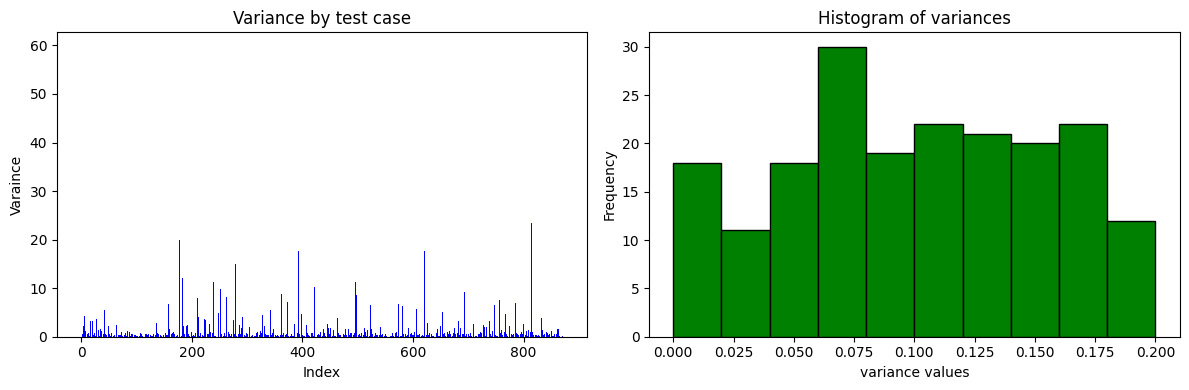

time: 1.47 s (started: 2023-12-14 18:57:43 +00:00)


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

# Bruteforce

In [15]:
from sklearn.metrics import jaccard_score


time: 386 µs (started: 2023-12-14 18:57:45 +00:00)


In [16]:
variance_list = []

for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    sim_dict = {}

    val_grams = set(trigrams(val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]))
    val_grams_cat = set(val_data.loc[val_data['ID'] == num, 'Category'].apply(lambda x: set(x.split(" | "))).values[0])
    
    jac_sim = lambda x: jaccard_similarity(x["Product Name"], val_grams)
    jac_sim_cat = lambda x: jaccard_similarity(x["Category"], val_grams_cat)

    _col = train_pname.apply(jac_sim, axis=1)
    _col = pd.concat([_col, train_cat.apply(jac_sim_cat, axis=1)]).sort_values(ascending=False)
    
    top_ids = list(_col.index)[:2]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])
variance_list = np.array(variance_list)
variance_list = variance_list[~np.isnan(variance_list)]
print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

100%|██████████| 872/872 [02:18<00:00,  6.29it/s]

mean variance: 1.402169935346122
median variance 0.5137875993864545
standard deviation 5.412177319773281
time: 2min 18s (started: 2023-12-14 18:57:45 +00:00)


In [17]:

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

mean variance: 1.402169935346122
median variance 0.5137875993864545
time: 1.27 ms (started: 2023-12-14 19:00:03 +00:00)


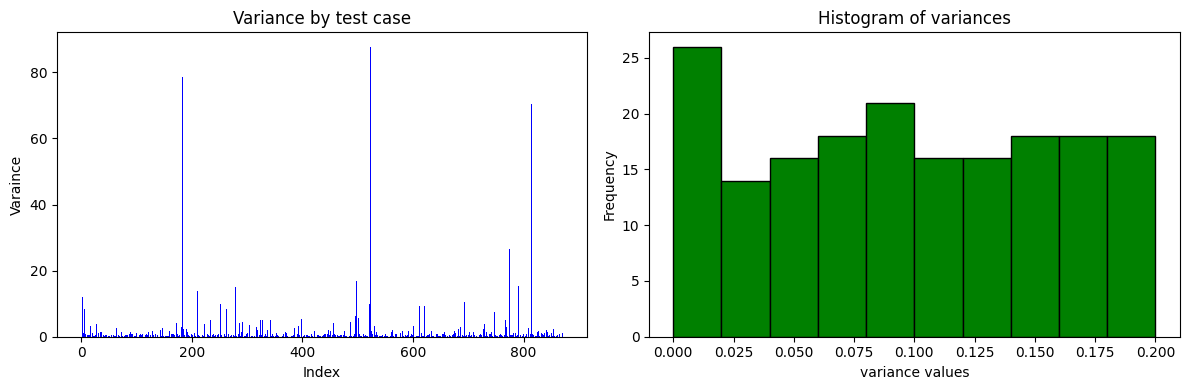

time: 1.69 s (started: 2023-12-14 19:00:03 +00:00)


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

# SimHash

In [19]:
!pip install faiss-cpu
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 66.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b259cf7ddc72ab5966ec82055aa334b6b319dd63d14bd9490a407d1cc3980c6a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
time: 23.6 s (started: 2023-12-14 19:00:05 +00:00)


In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('BAAI/bge-large-zh-v1.5')

pc_embeds = clear_data.apply(lambda x: model.encode("Product Title: " + x["Product Name"] + ", Category: " + x["Category"], normalize_embeddings=True), axis=1)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:01<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

time: 1h 7min 32s (started: 2023-12-14 19:00:29 +00:00)


In [21]:
pc_embeds.values[0].shape[0]

1024

time: 5.5 ms (started: 2023-12-14 20:08:02 +00:00)


In [22]:
import faiss

vals = np.concatenate(pc_embeds.values).reshape(len(pc_embeds), 1024)
d = vals.shape[1]

nbits = 2 * d
index = faiss.IndexLSH(d, nbits)
index.train(vals)
index.add(vals)

time: 1.16 s (started: 2023-12-14 20:08:02 +00:00)


In [23]:
D, I = index.search(vals[0].reshape(1, 1024), k=10)

time: 4.15 ms (started: 2023-12-14 20:08:03 +00:00)


In [24]:
vals[I[0]].shape

(10, 1024)

time: 5.57 ms (started: 2023-12-14 20:08:03 +00:00)


In [25]:
I

array([[   0, 8446, 7906, 3945, 7343, 6501, 6063, 5612, 4382, 1580]])

time: 5.54 ms (started: 2023-12-14 20:08:03 +00:00)


In [26]:
variance_list = []
from sentence_transformers.util import dot_score
for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    sim_dict = {}

    val_name = val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]
    val_cat = val_data.loc[val_data['ID'] == num, 'Category'].values[0]
    val_embed = model.encode("Product Title: " + val_name + ", Category: " + val_cat, normalize_embeddings=True)
    
    D, I = index.search(val_embed.reshape(1, 1024), k=2)
    
    top_ids = I[0]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])
variance_list = np.array(variance_list)
variance_list = variance_list[~np.isnan(variance_list)]
print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

  0%|          | 0/872 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/872 [00:00<07:08,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/872 [00:00<06:13,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/872 [00:01<05:53,  2.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 4/872 [00:01<05:54,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 5/872 [00:02<06:05,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 6/872 [00:02<06:34,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 7/872 [00:02<06:00,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 8/872 [00:03<06:13,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 9/872 [00:04<07:57,  1.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 10/872 [00:04<07:35,  1.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 11/872 [00:05<07:29,  1.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 12/872 [00:05<07:25,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 13/872 [00:06<06:58,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 14/872 [00:06<06:30,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 15/872 [00:06<06:16,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 16/872 [00:07<06:39,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 17/872 [00:07<06:40,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 18/872 [00:08<06:24,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 19/872 [00:08<06:23,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 20/872 [00:09<06:39,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 21/872 [00:09<06:52,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 22/872 [00:10<06:34,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 23/872 [00:10<07:10,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 24/872 [00:11<06:29,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 25/872 [00:11<06:18,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 26/872 [00:12<06:46,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 27/872 [00:12<06:59,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 28/872 [00:13<06:45,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 29/872 [00:13<06:35,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 30/872 [00:14<06:35,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 31/872 [00:14<06:35,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 32/872 [00:15<06:49,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 33/872 [00:15<06:27,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 34/872 [00:16<06:49,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 35/872 [00:16<07:38,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 36/872 [00:17<06:33,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 37/872 [00:17<05:59,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 38/872 [00:17<06:16,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 39/872 [00:18<07:13,  1.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 40/872 [00:18<06:35,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 41/872 [00:19<06:12,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 42/872 [00:19<06:03,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 43/872 [00:20<05:36,  2.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 44/872 [00:20<05:38,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 45/872 [00:20<05:36,  2.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 46/872 [00:21<05:46,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 47/872 [00:21<06:03,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 48/872 [00:22<06:10,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 49/872 [00:22<06:23,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 50/872 [00:23<05:51,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 51/872 [00:23<05:59,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 52/872 [00:23<05:45,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 53/872 [00:24<05:40,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 54/872 [00:24<05:37,  2.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 55/872 [00:25<05:37,  2.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 56/872 [00:25<05:36,  2.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 57/872 [00:26<05:54,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 58/872 [00:26<05:48,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 59/872 [00:26<05:53,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 60/872 [00:27<05:58,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 61/872 [00:27<05:49,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 62/872 [00:28<06:02,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 63/872 [00:28<06:31,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 64/872 [00:29<06:27,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 65/872 [00:29<06:33,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 66/872 [00:30<07:05,  1.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 67/872 [00:30<06:33,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 68/872 [00:31<06:54,  1.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 69/872 [00:32<07:39,  1.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 70/872 [00:32<07:44,  1.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 71/872 [00:33<07:07,  1.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 72/872 [00:33<06:29,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 73/872 [00:34<06:33,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 74/872 [00:34<06:09,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 75/872 [00:34<06:00,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 76/872 [00:35<06:18,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 77/872 [00:35<05:51,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 78/872 [00:36<05:17,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 79/872 [00:36<05:32,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 80/872 [00:36<05:36,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 81/872 [00:37<05:59,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 82/872 [00:37<05:49,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 83/872 [00:38<06:09,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 84/872 [00:38<06:01,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 85/872 [00:39<05:29,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 86/872 [00:39<05:29,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 87/872 [00:40<06:03,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 88/872 [00:40<06:10,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 89/872 [00:41<05:53,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 90/872 [00:41<05:49,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 91/872 [00:41<05:42,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 92/872 [00:42<05:15,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 93/872 [00:42<05:33,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 94/872 [00:43<05:31,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 95/872 [00:43<05:24,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 96/872 [00:43<05:29,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 97/872 [00:44<06:20,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 98/872 [00:45<06:06,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 99/872 [00:45<05:52,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 100/872 [00:45<05:36,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 101/872 [00:46<06:14,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 102/872 [00:46<05:55,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 103/872 [00:47<05:25,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 104/872 [00:47<05:36,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 105/872 [00:48<05:58,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 106/872 [00:48<06:00,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 107/872 [00:49<06:12,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 108/872 [00:49<06:02,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▎        | 109/872 [00:50<05:49,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 110/872 [00:50<05:18,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 111/872 [00:50<05:41,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 112/872 [00:51<05:31,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 113/872 [00:51<05:32,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 114/872 [00:52<05:31,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 115/872 [00:52<05:25,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 116/872 [00:53<05:17,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 117/872 [00:53<06:04,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 118/872 [00:54<06:08,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 119/872 [00:54<05:56,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 120/872 [00:55<05:45,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 121/872 [00:55<05:47,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 122/872 [00:56<05:58,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 123/872 [00:56<05:23,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 124/872 [00:57<06:45,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 125/872 [00:57<06:46,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 126/872 [00:58<06:23,  1.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 127/872 [00:58<06:21,  1.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 128/872 [00:58<05:47,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 129/872 [00:59<06:42,  1.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 130/872 [01:00<06:46,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 131/872 [01:00<06:31,  1.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 132/872 [01:01<06:12,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 133/872 [01:01<06:16,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 134/872 [01:02<05:44,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 135/872 [01:02<05:40,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 136/872 [01:02<05:19,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 137/872 [01:03<05:21,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 138/872 [01:03<04:55,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 139/872 [01:04<06:18,  1.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 140/872 [01:04<05:53,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 141/872 [01:05<05:52,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 142/872 [01:05<05:48,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 143/872 [01:06<05:33,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 144/872 [01:06<05:20,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 145/872 [01:07<05:13,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 146/872 [01:07<05:21,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 147/872 [01:08<05:46,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 148/872 [01:08<05:38,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 149/872 [01:09<06:29,  1.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 150/872 [01:09<06:20,  1.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 151/872 [01:10<06:31,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 152/872 [01:10<06:00,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 153/872 [01:11<05:58,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 154/872 [01:11<05:52,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 155/872 [01:12<05:37,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 156/872 [01:12<05:38,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 157/872 [01:13<05:39,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 158/872 [01:13<05:16,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 159/872 [01:13<05:16,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 160/872 [01:14<05:11,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 161/872 [01:14<05:30,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 162/872 [01:15<05:28,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 163/872 [01:15<05:30,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 164/872 [01:16<05:15,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 165/872 [01:16<05:24,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 166/872 [01:17<05:22,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 167/872 [01:17<05:34,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 168/872 [01:18<05:27,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 169/872 [01:18<05:33,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 170/872 [01:18<05:25,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 171/872 [01:19<05:17,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 172/872 [01:19<05:11,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 173/872 [01:20<05:33,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 174/872 [01:21<06:06,  1.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 175/872 [01:21<06:28,  1.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 176/872 [01:22<06:09,  1.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 177/872 [01:22<06:09,  1.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 178/872 [01:23<05:52,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 179/872 [01:23<05:49,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 180/872 [01:24<05:34,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 181/872 [01:24<05:35,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 182/872 [01:24<05:24,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 183/872 [01:25<04:54,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 184/872 [01:25<04:41,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 185/872 [01:26<05:02,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 186/872 [01:26<05:28,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 187/872 [01:27<05:16,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 188/872 [01:27<05:20,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 189/872 [01:28<05:08,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 190/872 [01:28<05:29,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 191/872 [01:29<05:22,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 192/872 [01:29<05:15,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 193/872 [01:30<05:31,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 194/872 [01:30<05:52,  1.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 195/872 [01:30<05:13,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 196/872 [01:31<05:35,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 197/872 [01:32<05:32,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 198/872 [01:32<05:14,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 199/872 [01:32<05:08,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 200/872 [01:33<04:54,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 201/872 [01:33<04:56,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 202/872 [01:34<04:50,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 203/872 [01:34<04:59,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 204/872 [01:35<04:49,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 205/872 [01:35<05:00,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 206/872 [01:35<05:00,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 207/872 [01:36<05:25,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 208/872 [01:36<05:03,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 209/872 [01:37<05:21,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 210/872 [01:37<05:20,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 211/872 [01:38<05:13,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 212/872 [01:38<05:06,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 213/872 [01:39<05:21,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 214/872 [01:40<06:01,  1.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 215/872 [01:40<05:36,  1.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 216/872 [01:40<05:21,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 217/872 [01:41<05:30,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 218/872 [01:42<05:34,  1.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 219/872 [01:42<05:20,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 220/872 [01:42<05:00,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 221/872 [01:43<05:00,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 222/872 [01:43<05:03,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 223/872 [01:44<05:16,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 224/872 [01:44<05:20,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 225/872 [01:45<05:27,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 226/872 [01:45<05:00,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 227/872 [01:46<05:18,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 228/872 [01:46<04:59,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 229/872 [01:47<04:53,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 230/872 [01:47<04:47,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 231/872 [01:47<04:30,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 232/872 [01:48<04:18,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 233/872 [01:48<04:14,  2.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 234/872 [01:49<04:54,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 235/872 [01:49<04:50,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 236/872 [01:50<05:01,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 237/872 [01:50<04:28,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 238/872 [01:50<04:35,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 239/872 [01:51<04:43,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 240/872 [01:51<04:35,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 241/872 [01:52<04:27,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 242/872 [01:52<04:31,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 243/872 [01:53<04:27,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 244/872 [01:53<04:24,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 245/872 [01:53<04:20,  2.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 246/872 [01:54<04:16,  2.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 247/872 [01:54<04:10,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 248/872 [01:55<04:11,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 249/872 [01:55<05:18,  1.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 250/872 [01:56<05:05,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 251/872 [01:56<05:06,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 252/872 [01:57<05:05,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 253/872 [01:57<05:05,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 254/872 [01:58<05:04,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 255/872 [01:59<05:45,  1.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 256/872 [01:59<05:22,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 257/872 [01:59<05:20,  1.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 258/872 [02:00<04:59,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 259/872 [02:00<04:45,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 260/872 [02:01<04:50,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 261/872 [02:01<04:46,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 262/872 [02:02<05:06,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 263/872 [02:02<04:31,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 264/872 [02:03<04:34,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 265/872 [02:03<04:32,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 266/872 [02:04<04:52,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 267/872 [02:04<04:57,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 268/872 [02:05<04:56,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 269/872 [02:05<04:47,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 270/872 [02:06<04:58,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 271/872 [02:06<04:42,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 272/872 [02:06<04:32,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 273/872 [02:07<04:46,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 274/872 [02:07<04:26,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 275/872 [02:08<04:46,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 276/872 [02:09<05:07,  1.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 277/872 [02:09<04:39,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 278/872 [02:09<04:19,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 279/872 [02:10<04:21,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 280/872 [02:10<04:22,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 281/872 [02:11<04:10,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 282/872 [02:11<04:08,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 283/872 [02:11<04:21,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 284/872 [02:12<04:17,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 285/872 [02:12<04:21,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 286/872 [02:13<04:27,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 287/872 [02:13<04:37,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 288/872 [02:14<04:18,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 289/872 [02:14<04:40,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 290/872 [02:15<04:35,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 291/872 [02:15<04:30,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 292/872 [02:16<04:28,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 293/872 [02:16<04:10,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 294/872 [02:17<04:29,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 295/872 [02:17<04:26,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 296/872 [02:17<04:26,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 297/872 [02:18<04:43,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 298/872 [02:18<04:28,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 299/872 [02:19<04:10,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 300/872 [02:19<04:15,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 301/872 [02:20<05:09,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 302/872 [02:20<04:45,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 303/872 [02:21<04:22,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 304/872 [02:21<04:38,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 305/872 [02:22<04:35,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 306/872 [02:22<04:46,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 307/872 [02:23<04:47,  1.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 308/872 [02:23<04:44,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 309/872 [02:24<04:31,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 310/872 [02:24<04:27,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 311/872 [02:25<04:21,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 312/872 [02:25<04:09,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 313/872 [02:26<04:12,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 314/872 [02:26<04:08,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 315/872 [02:27<04:39,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 316/872 [02:27<04:33,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 317/872 [02:28<04:22,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 318/872 [02:28<04:03,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 319/872 [02:28<03:59,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 320/872 [02:29<04:59,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 321/872 [02:30<04:45,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 322/872 [02:30<05:19,  1.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 323/872 [02:31<05:03,  1.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 324/872 [02:31<04:32,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 325/872 [02:32<04:26,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 326/872 [02:32<04:18,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 327/872 [02:32<04:05,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 328/872 [02:33<04:07,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 329/872 [02:33<03:52,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 330/872 [02:34<03:58,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 331/872 [02:34<04:04,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 332/872 [02:35<03:59,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 333/872 [02:35<03:52,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 334/872 [02:35<03:50,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 335/872 [02:36<03:54,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 336/872 [02:36<03:48,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 337/872 [02:37<04:17,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 338/872 [02:37<04:14,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 339/872 [02:38<04:05,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 340/872 [02:38<03:48,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 341/872 [02:39<03:50,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 342/872 [02:39<03:56,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 343/872 [02:40<03:59,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 344/872 [02:40<04:11,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 345/872 [02:41<04:04,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 346/872 [02:41<04:52,  1.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 347/872 [02:42<04:19,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 348/872 [02:42<04:03,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 349/872 [02:43<04:03,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 350/872 [02:43<04:27,  1.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 351/872 [02:44<04:05,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 352/872 [02:44<03:51,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 353/872 [02:44<03:49,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 354/872 [02:45<03:42,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 355/872 [02:45<03:46,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 356/872 [02:46<03:56,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 357/872 [02:46<03:55,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 358/872 [02:47<03:53,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 359/872 [02:47<04:19,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████▏     | 360/872 [02:48<04:06,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████▏     | 361/872 [02:48<04:06,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 362/872 [02:49<04:31,  1.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 363/872 [02:49<04:38,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 364/872 [02:50<04:23,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 365/872 [02:50<04:40,  1.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 366/872 [02:51<04:31,  1.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 367/872 [02:51<04:21,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 368/872 [02:52<04:01,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 369/872 [02:52<03:56,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 370/872 [02:53<03:40,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 371/872 [02:53<03:16,  2.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 372/872 [02:53<03:17,  2.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 373/872 [02:54<03:21,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 374/872 [02:54<03:29,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 375/872 [02:55<03:28,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 376/872 [02:55<03:45,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 377/872 [02:56<04:25,  1.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 378/872 [02:56<04:20,  1.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 379/872 [02:57<03:58,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 380/872 [02:57<03:52,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 381/872 [02:58<04:28,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 382/872 [02:59<04:53,  1.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 383/872 [02:59<04:31,  1.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 384/872 [03:00<04:21,  1.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 385/872 [03:00<03:57,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 386/872 [03:00<03:49,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 387/872 [03:01<03:44,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 388/872 [03:01<03:38,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 389/872 [03:02<03:29,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 390/872 [03:02<03:38,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 391/872 [03:03<03:30,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 392/872 [03:03<03:36,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 393/872 [03:04<03:59,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 394/872 [03:04<03:47,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 395/872 [03:05<04:08,  1.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 396/872 [03:05<04:01,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 397/872 [03:06<03:39,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 398/872 [03:06<03:28,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 399/872 [03:06<03:34,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 400/872 [03:07<03:26,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 401/872 [03:07<03:22,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 402/872 [03:08<03:24,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 403/872 [03:08<03:23,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 404/872 [03:09<03:17,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 405/872 [03:09<03:29,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 406/872 [03:09<03:27,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 407/872 [03:10<03:27,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 408/872 [03:10<03:16,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 409/872 [03:11<03:13,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 410/872 [03:11<03:39,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 411/872 [03:12<03:44,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 412/872 [03:12<03:36,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 413/872 [03:13<03:37,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 414/872 [03:13<03:35,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 415/872 [03:14<03:36,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 416/872 [03:14<03:24,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 417/872 [03:15<03:33,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 418/872 [03:15<03:23,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 419/872 [03:16<03:46,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 420/872 [03:16<03:29,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 421/872 [03:17<03:39,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 422/872 [03:17<03:22,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 423/872 [03:17<03:04,  2.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 424/872 [03:18<02:58,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 425/872 [03:18<03:10,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 426/872 [03:19<03:15,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 427/872 [03:19<03:13,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 428/872 [03:20<03:30,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 429/872 [03:20<03:25,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 430/872 [03:20<03:28,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 431/872 [03:21<03:23,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 432/872 [03:21<03:21,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 433/872 [03:22<03:19,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 434/872 [03:22<03:18,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 435/872 [03:23<03:10,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 436/872 [03:23<03:19,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 437/872 [03:24<03:54,  1.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 438/872 [03:24<03:48,  1.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 439/872 [03:25<04:11,  1.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 440/872 [03:25<03:43,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 441/872 [03:26<03:35,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 442/872 [03:26<03:37,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 443/872 [03:27<03:28,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 444/872 [03:27<03:19,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 445/872 [03:28<03:12,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 446/872 [03:28<03:08,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 447/872 [03:29<03:24,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 448/872 [03:29<03:22,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 449/872 [03:30<03:27,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 450/872 [03:30<03:30,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 451/872 [03:31<03:10,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 452/872 [03:31<03:10,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 453/872 [03:31<03:03,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 454/872 [03:32<03:08,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 455/872 [03:32<03:17,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 456/872 [03:33<03:06,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 457/872 [03:33<02:59,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 458/872 [03:34<03:05,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 459/872 [03:34<02:52,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 460/872 [03:34<02:58,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 461/872 [03:35<02:56,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 462/872 [03:36<03:17,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 463/872 [03:36<03:11,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 464/872 [03:36<02:58,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 465/872 [03:37<03:00,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 466/872 [03:37<03:00,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 467/872 [03:38<02:50,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 468/872 [03:38<02:51,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 469/872 [03:38<02:54,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 470/872 [03:39<02:48,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 471/872 [03:39<03:11,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 472/872 [03:40<03:19,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 473/872 [03:40<03:05,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 474/872 [03:41<02:55,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 475/872 [03:41<03:18,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 476/872 [03:42<02:54,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 477/872 [03:42<02:42,  2.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 478/872 [03:43<02:53,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 479/872 [03:43<03:04,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 480/872 [03:44<03:11,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 481/872 [03:44<03:10,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 482/872 [03:45<03:25,  1.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 483/872 [03:45<03:03,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 484/872 [03:46<03:01,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 485/872 [03:46<03:02,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 486/872 [03:46<02:48,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 487/872 [03:47<02:58,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 488/872 [03:47<03:10,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 489/872 [03:48<03:20,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 490/872 [03:49<03:13,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 491/872 [03:49<02:55,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 492/872 [03:49<02:53,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 493/872 [03:50<02:55,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 494/872 [03:50<02:59,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 495/872 [03:51<02:49,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 496/872 [03:51<02:45,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 497/872 [03:52<02:37,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 498/872 [03:52<02:36,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 499/872 [03:52<02:32,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 500/872 [03:53<02:42,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 501/872 [03:53<02:54,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 502/872 [03:54<02:47,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 503/872 [03:54<02:40,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 504/872 [03:55<02:37,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 505/872 [03:55<02:33,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 506/872 [03:55<02:41,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 507/872 [03:56<02:25,  2.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 508/872 [03:56<02:33,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 509/872 [03:57<02:33,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 510/872 [03:57<02:26,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▊    | 511/872 [03:57<02:29,  2.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▊    | 512/872 [03:58<02:29,  2.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 513/872 [03:58<02:32,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 514/872 [03:59<02:30,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 515/872 [03:59<02:30,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 516/872 [04:00<02:35,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 517/872 [04:00<02:29,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 518/872 [04:00<02:23,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 519/872 [04:01<02:24,  2.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 520/872 [04:01<02:22,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 521/872 [04:02<02:14,  2.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 522/872 [04:02<02:26,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 523/872 [04:02<02:29,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 524/872 [04:03<02:35,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 525/872 [04:03<02:27,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 526/872 [04:04<02:29,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 527/872 [04:04<02:29,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 528/872 [04:05<02:29,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 529/872 [04:05<02:26,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 530/872 [04:06<02:30,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 531/872 [04:06<02:42,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 532/872 [04:07<02:45,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 533/872 [04:07<02:45,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 534/872 [04:07<02:29,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 535/872 [04:08<02:33,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 536/872 [04:08<02:35,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 537/872 [04:09<02:41,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 538/872 [04:09<02:26,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 539/872 [04:10<02:29,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 540/872 [04:10<02:42,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 541/872 [04:11<02:40,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 542/872 [04:11<02:37,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 543/872 [04:12<02:28,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 544/872 [04:12<02:21,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▎   | 545/872 [04:12<02:11,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 546/872 [04:13<02:16,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 547/872 [04:13<02:38,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 548/872 [04:14<02:35,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 549/872 [04:14<02:41,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 550/872 [04:15<02:30,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 551/872 [04:15<02:22,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 552/872 [04:16<02:07,  2.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 553/872 [04:16<02:05,  2.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 554/872 [04:17<02:31,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 555/872 [04:17<02:31,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 556/872 [04:18<02:28,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 557/872 [04:18<02:19,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 558/872 [04:18<02:21,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 559/872 [04:19<02:24,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 560/872 [04:19<02:25,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 561/872 [04:20<02:21,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 562/872 [04:20<02:10,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 563/872 [04:21<02:09,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 564/872 [04:21<02:10,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 565/872 [04:21<02:10,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 566/872 [04:22<02:20,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 567/872 [04:22<02:21,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 568/872 [04:23<02:12,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 569/872 [04:23<02:02,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 570/872 [04:24<02:02,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 571/872 [04:24<02:17,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 572/872 [04:25<02:21,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 573/872 [04:25<02:26,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 574/872 [04:26<02:29,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 575/872 [04:26<02:20,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 576/872 [04:26<02:12,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 577/872 [04:27<02:15,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 578/872 [04:27<02:13,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 579/872 [04:28<02:10,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 580/872 [04:28<02:01,  2.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 581/872 [04:29<02:13,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 582/872 [04:29<02:05,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 583/872 [04:30<02:04,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 584/872 [04:30<02:00,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 585/872 [04:30<01:56,  2.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 586/872 [04:31<02:12,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 587/872 [04:31<02:11,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 588/872 [04:32<02:19,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 589/872 [04:32<02:16,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 590/872 [04:33<02:16,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 591/872 [04:33<02:16,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 592/872 [04:34<02:07,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 593/872 [04:34<02:12,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 594/872 [04:35<02:09,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 595/872 [04:35<02:14,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 596/872 [04:36<02:19,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 597/872 [04:36<02:18,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 598/872 [04:37<02:23,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 599/872 [04:37<02:17,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 600/872 [04:38<02:01,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 601/872 [04:38<01:57,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 602/872 [04:38<01:55,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 603/872 [04:39<02:00,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 604/872 [04:39<01:53,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 605/872 [04:40<01:54,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 606/872 [04:40<02:00,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 607/872 [04:41<01:59,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 608/872 [04:41<01:52,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 609/872 [04:41<01:47,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 610/872 [04:42<01:58,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 611/872 [04:43<02:11,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 612/872 [04:43<02:01,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 613/872 [04:43<01:58,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 614/872 [04:44<01:56,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 615/872 [04:44<01:56,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 616/872 [04:45<01:53,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 617/872 [04:45<02:01,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 618/872 [04:46<02:06,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 619/872 [04:46<02:03,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 620/872 [04:47<02:13,  1.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 621/872 [04:47<01:59,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 622/872 [04:48<02:02,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 623/872 [04:48<02:10,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 624/872 [04:49<02:04,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 625/872 [04:49<01:57,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 626/872 [04:50<01:46,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 627/872 [04:50<01:54,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 628/872 [04:51<01:57,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 629/872 [04:51<01:54,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 630/872 [04:52<01:48,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 631/872 [04:52<01:53,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 632/872 [04:53<01:58,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 633/872 [04:53<01:49,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 634/872 [04:53<01:54,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 635/872 [04:54<01:50,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 636/872 [04:54<01:50,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 637/872 [04:55<01:59,  1.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 638/872 [04:55<01:46,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 639/872 [04:56<01:48,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 640/872 [04:56<01:40,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 641/872 [04:57<01:48,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 642/872 [04:57<01:44,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 643/872 [04:58<01:46,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 644/872 [04:58<01:54,  1.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 645/872 [04:59<01:51,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 646/872 [04:59<01:51,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 647/872 [05:00<01:57,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 648/872 [05:00<01:50,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 649/872 [05:01<02:05,  1.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 650/872 [05:01<01:51,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 651/872 [05:02<01:46,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 652/872 [05:02<01:40,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 653/872 [05:03<01:35,  2.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 654/872 [05:03<01:30,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 655/872 [05:03<01:26,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 656/872 [05:04<01:39,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 657/872 [05:04<01:29,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 658/872 [05:05<01:30,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 659/872 [05:05<01:28,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 660/872 [05:06<01:39,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 661/872 [05:06<01:30,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 662/872 [05:06<01:27,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 663/872 [05:07<01:27,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 664/872 [05:07<01:23,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 665/872 [05:08<01:23,  2.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 666/872 [05:08<01:37,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 667/872 [05:09<01:35,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 668/872 [05:09<01:30,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 669/872 [05:09<01:29,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 670/872 [05:10<01:22,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 671/872 [05:10<01:21,  2.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 672/872 [05:11<01:23,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 673/872 [05:11<01:22,  2.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 674/872 [05:11<01:25,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 675/872 [05:12<01:32,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 676/872 [05:12<01:31,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 677/872 [05:13<01:26,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 678/872 [05:14<01:45,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 679/872 [05:14<01:36,  2.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 680/872 [05:15<01:33,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 681/872 [05:15<01:32,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 682/872 [05:15<01:32,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 683/872 [05:16<01:30,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 684/872 [05:16<01:26,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 685/872 [05:17<01:27,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 686/872 [05:17<01:26,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 687/872 [05:18<01:32,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 688/872 [05:18<01:27,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 689/872 [05:19<01:34,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 690/872 [05:19<01:33,  1.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 691/872 [05:20<01:34,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 692/872 [05:20<01:26,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 693/872 [05:21<01:22,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 694/872 [05:21<01:19,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 695/872 [05:22<01:23,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 696/872 [05:22<01:17,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 697/872 [05:23<01:20,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 698/872 [05:23<01:11,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 699/872 [05:23<01:16,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 700/872 [05:24<01:11,  2.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 701/872 [05:24<01:08,  2.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 702/872 [05:25<01:13,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 703/872 [05:25<01:12,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 704/872 [05:26<01:17,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 705/872 [05:26<01:15,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 706/872 [05:26<01:13,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 707/872 [05:27<01:25,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 708/872 [05:28<01:19,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 709/872 [05:28<01:13,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 710/872 [05:28<01:08,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 711/872 [05:29<01:06,  2.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 712/872 [05:29<01:09,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 713/872 [05:30<01:06,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 714/872 [05:30<01:15,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 715/872 [05:31<01:11,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 716/872 [05:31<01:10,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 717/872 [05:31<01:11,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 718/872 [05:32<01:12,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 719/872 [05:32<01:10,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 720/872 [05:33<01:10,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 721/872 [05:33<01:08,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 722/872 [05:34<01:02,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 723/872 [05:34<01:06,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 724/872 [05:35<01:08,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 725/872 [05:35<01:05,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 726/872 [05:35<01:04,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 727/872 [05:36<01:08,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 728/872 [05:37<01:09,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 729/872 [05:37<01:06,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 730/872 [05:37<01:05,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 731/872 [05:38<01:07,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 732/872 [05:38<01:04,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 733/872 [05:39<01:04,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 734/872 [05:39<01:07,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 735/872 [05:40<01:07,  2.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 736/872 [05:40<01:05,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 737/872 [05:41<01:00,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 738/872 [05:41<01:01,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 739/872 [05:42<01:03,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 740/872 [05:42<00:59,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 741/872 [05:42<00:55,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 742/872 [05:43<00:57,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 743/872 [05:43<00:54,  2.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 744/872 [05:44<00:54,  2.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 745/872 [05:44<00:53,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 746/872 [05:45<00:56,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 747/872 [05:45<01:03,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 748/872 [05:46<00:57,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 749/872 [05:46<00:52,  2.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 750/872 [05:46<00:54,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 751/872 [05:47<00:49,  2.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 752/872 [05:47<00:50,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 753/872 [05:48<00:51,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 754/872 [05:48<00:52,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 755/872 [05:49<00:50,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 756/872 [05:49<00:51,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 757/872 [05:50<00:52,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 758/872 [05:50<00:55,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 759/872 [05:50<00:51,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 760/872 [05:51<00:47,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 761/872 [05:51<00:46,  2.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 762/872 [05:52<00:42,  2.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 763/872 [05:52<00:46,  2.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 764/872 [05:53<00:52,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 765/872 [05:53<00:50,  2.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 766/872 [05:54<00:47,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 767/872 [05:54<00:45,  2.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 768/872 [05:54<00:47,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 769/872 [05:55<00:49,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 770/872 [05:55<00:47,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 771/872 [05:56<00:46,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 772/872 [05:56<00:44,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 773/872 [05:57<00:44,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 774/872 [05:57<00:45,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 775/872 [05:58<00:45,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 776/872 [05:58<00:41,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 777/872 [05:59<00:47,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 778/872 [05:59<00:45,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 779/872 [06:00<00:42,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 780/872 [06:00<00:44,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 781/872 [06:01<00:45,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 782/872 [06:01<00:42,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 783/872 [06:01<00:40,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 784/872 [06:02<00:41,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 785/872 [06:02<00:39,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 786/872 [06:03<00:41,  2.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 787/872 [06:03<00:41,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 788/872 [06:04<00:39,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 789/872 [06:04<00:36,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 790/872 [06:05<00:40,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 791/872 [06:05<00:39,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 792/872 [06:06<00:38,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 793/872 [06:06<00:42,  1.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 794/872 [06:07<00:43,  1.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 795/872 [06:08<00:40,  1.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 796/872 [06:08<00:39,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 797/872 [06:08<00:37,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 798/872 [06:09<00:36,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 799/872 [06:09<00:33,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 800/872 [06:10<00:35,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 801/872 [06:10<00:33,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 802/872 [06:11<00:33,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 803/872 [06:11<00:30,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 804/872 [06:12<00:30,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 805/872 [06:12<00:33,  2.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 806/872 [06:13<00:30,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 807/872 [06:13<00:29,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 808/872 [06:14<00:29,  2.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 809/872 [06:14<00:30,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 810/872 [06:15<00:29,  2.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 811/872 [06:15<00:29,  2.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 812/872 [06:16<00:29,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 813/872 [06:16<00:27,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 814/872 [06:16<00:23,  2.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 815/872 [06:17<00:23,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 816/872 [06:17<00:22,  2.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 817/872 [06:17<00:21,  2.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 818/872 [06:18<00:23,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 819/872 [06:18<00:24,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 820/872 [06:19<00:24,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 821/872 [06:20<00:27,  1.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 822/872 [06:20<00:25,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 823/872 [06:20<00:22,  2.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 824/872 [06:21<00:21,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 825/872 [06:21<00:20,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 826/872 [06:22<00:22,  2.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 827/872 [06:22<00:21,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 828/872 [06:23<00:20,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 829/872 [06:23<00:21,  1.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 830/872 [06:24<00:23,  1.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 831/872 [06:25<00:23,  1.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 832/872 [06:25<00:21,  1.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 833/872 [06:26<00:21,  1.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 834/872 [06:26<00:20,  1.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 835/872 [06:27<00:18,  2.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 836/872 [06:27<00:17,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 837/872 [06:28<00:16,  2.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 838/872 [06:28<00:15,  2.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 839/872 [06:28<00:15,  2.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 840/872 [06:29<00:17,  1.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 841/872 [06:30<00:16,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 842/872 [06:30<00:15,  1.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 843/872 [06:30<00:13,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 844/872 [06:31<00:12,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 845/872 [06:31<00:12,  2.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 846/872 [06:32<00:11,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 847/872 [06:32<00:10,  2.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 848/872 [06:33<00:10,  2.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 849/872 [06:33<00:10,  2.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 850/872 [06:34<00:09,  2.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 851/872 [06:34<00:10,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 852/872 [06:35<00:09,  2.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 853/872 [06:35<00:08,  2.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 854/872 [06:35<00:08,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 855/872 [06:36<00:07,  2.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 856/872 [06:36<00:07,  2.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 857/872 [06:37<00:06,  2.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 858/872 [06:37<00:06,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 859/872 [06:38<00:05,  2.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 860/872 [06:38<00:05,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 861/872 [06:38<00:04,  2.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 862/872 [06:39<00:04,  2.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 863/872 [06:39<00:04,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 864/872 [06:40<00:03,  2.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 865/872 [06:40<00:02,  2.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 866/872 [06:41<00:02,  2.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 867/872 [06:41<00:02,  2.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 868/872 [06:42<00:01,  2.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 869/872 [06:42<00:01,  2.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 870/872 [06:43<00:00,  2.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 871/872 [06:43<00:00,  2.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 872/872 [06:44<00:00,  2.16it/s]

mean variance: 0.5005259333106313
median variance 0.2053210017609267
standard deviation 2.95632382555176
time: 6min 44s (started: 2023-12-14 20:08:03 +00:00)


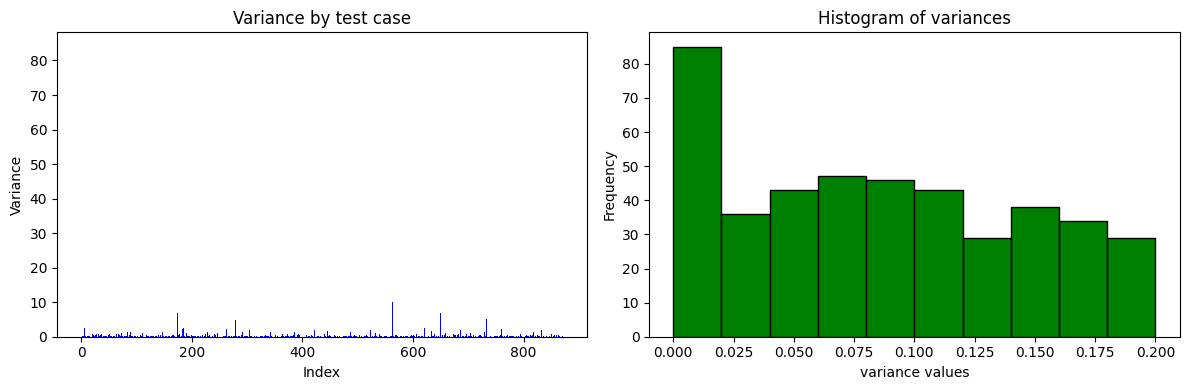

time: 1.45 s (started: 2023-12-14 20:14:47 +00:00)


In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Variance')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

# Cosine Similarity Bruteforce

In [28]:
from sentence_transformers.util import dot_score
variance_list = []

for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    sim_dict = {}

    val_name = val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]
    val_cat = val_data.loc[val_data['ID'] == num, 'Category'].values[0]
    val_embed = model.encode("Product Title: " + val_name + ", Category: " + val_cat, normalize_embeddings=True)

    cos_sim = lambda x: dot_score(x, val_embed)

    _col = pc_embeds.apply(cos_sim).sort_values(ascending=False)
    
    top_ids = list(_col.index)[:2]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])
variance_list = np.array(variance_list)
variance_list = variance_list[~np.isnan(variance_list)]
print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))
print("standard deviation", np.std(variance_list))

  0%|          | 0/872 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/872 [00:01<14:39,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/872 [00:01<14:08,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 3/872 [00:02<14:05,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 4/872 [00:03<14:04,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 5/872 [00:04<14:15,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 6/872 [00:06<14:47,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 7/872 [00:06<14:15,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 8/872 [00:07<14:10,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 9/872 [00:09<14:57,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 10/872 [00:10<14:55,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 11/872 [00:11<15:01,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 12/872 [00:12<15:04,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 13/872 [00:13<14:53,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 14/872 [00:14<14:33,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 15/872 [00:15<14:30,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 16/872 [00:16<14:49,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 17/872 [00:17<14:47,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 18/872 [00:18<14:43,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 19/872 [00:20<20:40,  1.45s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 20/872 [00:21<19:08,  1.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 21/872 [00:22<17:53,  1.26s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 22/872 [00:23<16:36,  1.17s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 23/872 [00:25<16:32,  1.17s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 24/872 [00:25<15:22,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 25/872 [00:26<14:54,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 26/872 [00:28<15:14,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 27/872 [00:29<15:19,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 28/872 [00:30<15:16,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 29/872 [00:31<14:56,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 30/872 [00:32<14:45,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 31/872 [00:33<14:43,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 32/872 [00:34<15:08,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 33/872 [00:35<14:40,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 34/872 [00:36<15:11,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 35/872 [00:38<16:27,  1.18s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 36/872 [00:39<15:24,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 37/872 [00:39<14:36,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 38/872 [00:40<14:24,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 39/872 [00:42<15:09,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 40/872 [00:43<14:34,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 41/872 [00:44<14:10,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 42/872 [00:45<14:09,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 43/872 [00:46<13:45,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 44/872 [00:46<13:37,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 45/872 [00:47<13:29,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 46/872 [00:48<13:33,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 47/872 [00:50<13:50,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 48/872 [00:51<13:53,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 49/872 [00:52<13:54,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 50/872 [00:52<13:25,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 51/872 [00:53<13:23,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 52/872 [00:54<13:16,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 53/872 [00:55<13:12,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 54/872 [00:56<13:13,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 55/872 [00:57<13:05,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 56/872 [00:58<13:03,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 57/872 [00:59<13:28,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 58/872 [01:00<13:13,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 59/872 [01:01<13:14,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 60/872 [01:02<13:16,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 61/872 [01:03<13:17,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 62/872 [01:04<13:27,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 63/872 [01:05<13:46,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 64/872 [01:06<13:37,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 65/872 [01:07<13:55,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 66/872 [01:09<14:43,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 67/872 [01:10<14:11,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 68/872 [01:11<14:35,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 69/872 [01:12<15:12,  1.14s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 70/872 [01:13<15:19,  1.15s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 71/872 [01:14<14:44,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 72/872 [01:15<14:08,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 73/872 [01:16<14:06,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 74/872 [01:17<13:29,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 75/872 [01:18<13:20,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 76/872 [01:19<13:05,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 77/872 [01:20<12:57,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 78/872 [01:21<12:46,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 79/872 [01:22<12:50,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 80/872 [01:23<12:54,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 81/872 [01:24<13:16,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 82/872 [01:25<13:01,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 83/872 [01:26<13:24,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 84/872 [01:27<12:59,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 85/872 [01:28<12:36,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 86/872 [01:29<12:37,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 87/872 [01:30<12:51,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 88/872 [01:31<13:06,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 89/872 [01:32<12:49,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 90/872 [01:33<12:39,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 91/872 [01:34<12:39,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 92/872 [01:35<12:14,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 93/872 [01:36<12:38,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 94/872 [01:37<12:39,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 95/872 [01:38<12:26,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 96/872 [01:39<12:32,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 97/872 [01:40<13:41,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 98/872 [01:41<13:08,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 99/872 [01:42<12:46,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 100/872 [01:43<12:37,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 101/872 [01:44<13:13,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 102/872 [01:46<17:55,  1.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 103/872 [01:47<16:01,  1.25s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 104/872 [01:48<15:14,  1.19s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 105/872 [01:49<14:52,  1.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 106/872 [01:50<14:10,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 107/872 [01:51<13:59,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 108/872 [01:52<13:21,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▎        | 109/872 [01:53<12:47,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 110/872 [01:54<12:31,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 111/872 [01:55<12:47,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 112/872 [01:56<12:34,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 113/872 [01:57<12:18,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 114/872 [01:58<12:18,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 115/872 [01:59<12:20,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 116/872 [02:00<12:15,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 117/872 [02:01<12:49,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 118/872 [02:02<12:50,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 119/872 [02:03<12:32,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 120/872 [02:04<12:33,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 121/872 [02:05<12:30,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 122/872 [02:06<12:36,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 123/872 [02:07<12:04,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 124/872 [02:08<13:26,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 125/872 [02:09<13:24,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 126/872 [02:10<13:08,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 127/872 [02:11<13:27,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 128/872 [02:12<12:46,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 129/872 [02:14<13:35,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 130/872 [02:15<13:40,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 131/872 [02:16<13:20,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 132/872 [02:17<12:56,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 133/872 [02:18<12:57,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 134/872 [02:19<12:33,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 135/872 [02:20<12:28,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 136/872 [02:21<12:03,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 137/872 [02:22<12:17,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 138/872 [02:22<11:46,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 139/872 [02:24<13:18,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 140/872 [02:25<12:52,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 141/872 [02:26<12:48,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 142/872 [02:27<12:41,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 143/872 [02:28<12:23,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 144/872 [02:29<11:56,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 145/872 [02:30<11:47,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 146/872 [02:31<11:54,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 147/872 [02:32<12:22,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 148/872 [02:33<12:08,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 149/872 [02:34<12:55,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 150/872 [02:35<12:45,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 151/872 [02:36<12:33,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 152/872 [02:37<12:11,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 153/872 [02:38<12:12,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 154/872 [02:39<11:56,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 155/872 [02:40<11:50,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 156/872 [02:41<12:02,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 157/872 [02:42<12:19,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 158/872 [02:43<11:53,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 159/872 [02:44<11:44,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 160/872 [02:45<11:35,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 161/872 [02:46<11:46,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 162/872 [02:47<11:54,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 163/872 [02:48<12:04,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 164/872 [02:49<11:38,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 165/872 [02:50<11:43,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 166/872 [02:51<11:40,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 167/872 [02:52<11:56,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 168/872 [02:53<11:56,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 169/872 [02:54<12:11,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 170/872 [02:55<11:57,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 171/872 [02:56<11:48,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 172/872 [02:57<11:29,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 173/872 [02:58<11:37,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 174/872 [02:59<11:47,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 175/872 [03:00<11:58,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 176/872 [03:01<11:30,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 177/872 [03:02<11:34,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 178/872 [03:03<11:35,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 179/872 [03:04<11:41,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 180/872 [03:05<11:23,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 181/872 [03:06<11:21,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 182/872 [03:07<11:18,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 183/872 [03:08<10:51,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 184/872 [03:09<10:56,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 185/872 [03:10<11:17,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 186/872 [03:12<16:19,  1.43s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 187/872 [03:13<14:54,  1.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 188/872 [03:14<14:03,  1.23s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 189/872 [03:15<12:59,  1.14s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 190/872 [03:16<12:41,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 191/872 [03:17<12:14,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 192/872 [03:18<11:58,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 193/872 [03:19<11:50,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 194/872 [03:21<12:00,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 195/872 [03:21<11:21,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 196/872 [03:23<11:43,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 197/872 [03:24<11:42,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 198/872 [03:25<11:19,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 199/872 [03:26<11:12,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 200/872 [03:26<10:58,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 201/872 [03:27<10:56,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 202/872 [03:28<10:52,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 203/872 [03:29<11:09,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 204/872 [03:30<11:15,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 205/872 [03:32<11:29,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 206/872 [03:33<11:21,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 207/872 [03:34<11:47,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 208/872 [03:35<11:21,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 209/872 [03:36<11:33,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 210/872 [03:37<11:37,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 211/872 [03:38<11:37,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 212/872 [03:39<11:34,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 213/872 [03:40<11:34,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 214/872 [03:41<12:09,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 215/872 [03:42<11:39,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 216/872 [03:43<11:19,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 217/872 [03:44<11:43,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 218/872 [03:45<11:47,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 219/872 [03:46<11:22,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 220/872 [03:47<11:00,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 221/872 [03:48<11:02,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 222/872 [03:49<10:59,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 223/872 [03:50<11:16,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 224/872 [03:52<11:16,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 225/872 [03:53<11:16,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 226/872 [03:53<10:50,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 227/872 [03:55<11:17,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 228/872 [03:56<10:54,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 229/872 [03:57<10:47,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 230/872 [03:58<10:34,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 231/872 [03:58<10:23,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 232/872 [03:59<10:07,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 233/872 [04:00<10:05,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 234/872 [04:01<10:37,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 235/872 [04:02<10:35,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 236/872 [04:03<10:44,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 237/872 [04:04<10:24,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 238/872 [04:05<10:30,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 239/872 [04:06<10:35,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 240/872 [04:07<10:27,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 241/872 [04:08<10:16,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 242/872 [04:09<10:25,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 243/872 [04:10<10:19,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 244/872 [04:11<10:21,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 245/872 [04:12<10:11,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 246/872 [04:13<10:04,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 247/872 [04:14<09:55,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 248/872 [04:15<09:53,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 249/872 [04:16<11:12,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 250/872 [04:17<10:55,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 251/872 [04:18<10:48,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 252/872 [04:19<10:37,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 253/872 [04:20<10:38,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 254/872 [04:21<10:31,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 255/872 [04:23<10:58,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 256/872 [04:24<10:33,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 257/872 [04:25<10:32,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 258/872 [04:26<10:26,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 259/872 [04:27<10:12,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 260/872 [04:28<10:25,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 261/872 [04:29<10:24,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 262/872 [04:30<10:49,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 263/872 [04:31<10:09,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 264/872 [04:32<10:08,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 265/872 [04:33<10:06,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 266/872 [04:34<10:04,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 267/872 [04:35<10:10,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 268/872 [04:36<10:04,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 269/872 [04:37<09:58,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 270/872 [04:39<14:20,  1.43s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 271/872 [04:40<13:08,  1.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 272/872 [04:41<12:06,  1.21s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 273/872 [04:42<11:24,  1.14s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 274/872 [04:43<10:50,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 275/872 [04:44<10:49,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 276/872 [04:45<10:43,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 277/872 [04:46<10:13,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 278/872 [04:47<09:47,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 279/872 [04:48<09:43,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 280/872 [04:49<09:36,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 281/872 [04:50<09:22,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 282/872 [04:51<09:20,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 283/872 [04:52<09:25,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 284/872 [04:53<09:32,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 285/872 [04:54<09:42,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 286/872 [04:55<09:50,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 287/872 [04:56<09:42,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 288/872 [04:57<09:29,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 289/872 [04:58<09:55,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 290/872 [04:59<09:59,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 291/872 [05:00<09:50,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 292/872 [05:01<09:44,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 293/872 [05:02<09:30,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 294/872 [05:03<09:46,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 295/872 [05:04<09:45,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 296/872 [05:05<09:42,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 297/872 [05:06<10:05,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 298/872 [05:07<09:48,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 299/872 [05:08<09:32,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 300/872 [05:09<09:29,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 301/872 [05:10<10:14,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 302/872 [05:11<10:02,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 303/872 [05:12<09:40,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 304/872 [05:13<09:55,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 305/872 [05:14<09:56,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 306/872 [05:16<10:08,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 307/872 [05:17<10:09,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 308/872 [05:18<10:12,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 309/872 [05:19<09:59,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 310/872 [05:20<09:49,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 311/872 [05:21<09:38,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 312/872 [05:22<09:22,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 313/872 [05:23<09:24,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 314/872 [05:24<09:12,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 315/872 [05:25<09:41,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 316/872 [05:26<09:33,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 317/872 [05:27<09:20,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 318/872 [05:28<08:57,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 319/872 [05:29<08:56,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 320/872 [05:30<09:58,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 321/872 [05:31<09:38,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 322/872 [05:32<10:13,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 323/872 [05:33<09:59,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 324/872 [05:34<09:33,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 325/872 [05:35<09:27,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 326/872 [05:36<09:06,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 327/872 [05:37<08:57,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 328/872 [05:38<09:09,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 329/872 [05:39<08:49,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 330/872 [05:40<08:53,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 331/872 [05:41<08:54,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 332/872 [05:42<08:53,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 333/872 [05:43<08:43,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 334/872 [05:44<08:51,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 335/872 [05:45<08:53,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 336/872 [05:46<08:43,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 337/872 [05:47<09:06,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 338/872 [05:48<09:12,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 339/872 [05:49<09:25,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 340/872 [05:50<09:00,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 341/872 [05:51<08:49,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 342/872 [05:52<08:53,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 343/872 [05:53<08:42,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 344/872 [05:54<08:53,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 345/872 [05:55<08:43,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 346/872 [05:56<09:33,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 347/872 [05:57<08:59,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 348/872 [05:58<08:52,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 349/872 [05:59<08:51,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 350/872 [06:00<09:11,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 351/872 [06:01<08:41,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 352/872 [06:02<08:29,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 353/872 [06:03<08:24,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 354/872 [06:04<08:28,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 355/872 [06:07<12:04,  1.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 356/872 [06:08<11:18,  1.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 357/872 [06:09<10:19,  1.20s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 358/872 [06:10<09:53,  1.15s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 359/872 [06:11<09:53,  1.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████▏     | 360/872 [06:12<09:23,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████▏     | 361/872 [06:13<09:09,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 362/872 [06:14<09:34,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 363/872 [06:15<09:33,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 364/872 [06:16<09:10,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 365/872 [06:17<09:28,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 366/872 [06:18<09:20,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 367/872 [06:20<09:17,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 368/872 [06:21<09:00,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 369/872 [06:22<08:52,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 370/872 [06:23<08:33,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 371/872 [06:23<08:11,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 372/872 [06:24<08:10,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 373/872 [06:25<08:11,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 374/872 [06:26<08:06,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 375/872 [06:27<08:10,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 376/872 [06:28<08:26,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 377/872 [06:30<09:00,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 378/872 [06:31<08:55,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 379/872 [06:32<08:29,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 380/872 [06:33<08:31,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 381/872 [06:34<09:13,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 382/872 [06:35<09:37,  1.18s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 383/872 [06:36<09:09,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 384/872 [06:37<08:54,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 385/872 [06:38<08:30,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 386/872 [06:39<08:19,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 387/872 [06:40<08:05,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 388/872 [06:41<08:09,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 389/872 [06:42<08:05,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 390/872 [06:43<08:09,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 391/872 [06:44<08:03,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 392/872 [06:45<08:02,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 393/872 [06:46<08:23,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 394/872 [06:47<08:06,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 395/872 [06:48<08:17,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 396/872 [06:50<08:19,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 397/872 [06:51<08:10,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 398/872 [06:52<08:01,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 399/872 [06:53<08:07,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 400/872 [06:54<07:51,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 401/872 [06:54<07:42,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 402/872 [06:55<07:42,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 403/872 [06:56<07:39,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 404/872 [06:57<07:33,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 405/872 [06:58<07:40,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 406/872 [06:59<07:42,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 407/872 [07:00<07:43,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 408/872 [07:01<07:28,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 409/872 [07:02<07:24,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 410/872 [07:03<07:39,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 411/872 [07:04<07:46,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 412/872 [07:05<07:38,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 413/872 [07:06<07:41,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 414/872 [07:07<07:34,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 415/872 [07:08<07:44,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 416/872 [07:09<07:30,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 417/872 [07:10<07:40,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 418/872 [07:11<07:21,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 419/872 [07:12<07:49,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 420/872 [07:13<07:38,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 421/872 [07:15<07:49,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 422/872 [07:15<07:34,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 423/872 [07:16<07:15,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 424/872 [07:17<07:02,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 425/872 [07:18<07:15,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 426/872 [07:19<07:23,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 427/872 [07:20<07:18,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 428/872 [07:21<07:40,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 429/872 [07:22<07:37,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 430/872 [07:23<07:37,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 431/872 [07:25<07:34,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 432/872 [07:26<07:29,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 433/872 [07:26<07:22,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 434/872 [07:27<07:20,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 435/872 [07:28<07:16,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 436/872 [07:30<07:20,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 437/872 [07:31<07:56,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 438/872 [07:32<07:44,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 439/872 [07:33<08:11,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 440/872 [07:35<10:50,  1.51s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 441/872 [07:36<09:36,  1.34s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 442/872 [07:37<08:46,  1.22s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 443/872 [07:38<08:16,  1.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 444/872 [07:39<07:49,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 445/872 [07:40<07:29,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 446/872 [07:41<07:15,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 447/872 [07:42<07:20,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 448/872 [07:43<07:12,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 449/872 [07:44<07:16,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 450/872 [07:45<07:13,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 451/872 [07:46<06:58,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 452/872 [07:47<06:58,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 453/872 [07:48<06:59,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 454/872 [07:49<06:57,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 455/872 [07:50<07:05,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 456/872 [07:51<06:50,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 457/872 [07:52<06:39,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 458/872 [07:53<07:04,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 459/872 [07:54<06:52,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 460/872 [07:55<06:56,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 461/872 [07:56<06:45,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 462/872 [07:57<07:00,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 463/872 [07:58<06:52,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 464/872 [07:59<06:40,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 465/872 [08:00<06:43,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 466/872 [08:01<06:48,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 467/872 [08:02<06:36,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 468/872 [08:03<06:36,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 469/872 [08:04<06:41,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 470/872 [08:05<06:27,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 471/872 [08:06<06:53,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 472/872 [08:07<06:56,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 473/872 [08:08<06:42,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 474/872 [08:09<06:35,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 475/872 [08:10<06:47,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 476/872 [08:11<06:30,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 477/872 [08:12<06:12,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 478/872 [08:13<06:16,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 479/872 [08:14<06:17,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 480/872 [08:15<06:28,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 481/872 [08:16<06:31,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 482/872 [08:17<06:51,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 483/872 [08:18<06:33,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 484/872 [08:19<06:29,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 485/872 [08:20<06:32,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 486/872 [08:21<06:20,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 487/872 [08:22<06:28,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 488/872 [08:23<06:44,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 489/872 [08:25<07:03,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 490/872 [08:26<06:49,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 491/872 [08:27<06:28,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 492/872 [08:27<06:21,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 493/872 [08:29<06:23,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 494/872 [08:30<06:27,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 495/872 [08:31<06:18,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 496/872 [08:32<06:17,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 497/872 [08:32<06:08,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 498/872 [08:33<06:04,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 499/872 [08:34<06:00,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 500/872 [08:35<06:09,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 501/872 [08:36<06:16,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 502/872 [08:38<06:15,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 503/872 [08:38<06:04,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 504/872 [08:39<06:00,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 505/872 [08:40<05:53,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 506/872 [08:41<06:05,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 507/872 [08:42<05:49,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 508/872 [08:43<05:55,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 509/872 [08:44<05:55,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 510/872 [08:45<05:50,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▊    | 511/872 [08:46<05:52,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▊    | 512/872 [08:47<05:52,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 513/872 [08:48<05:58,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 514/872 [08:49<05:56,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 515/872 [08:50<05:53,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 516/872 [08:51<05:56,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 517/872 [08:52<05:52,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 518/872 [08:53<05:43,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 519/872 [08:54<05:41,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 520/872 [08:55<05:44,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 521/872 [08:56<05:36,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 522/872 [08:57<05:45,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 523/872 [08:58<05:47,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 524/872 [08:59<05:51,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 525/872 [09:00<05:38,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 526/872 [09:02<08:01,  1.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 527/872 [09:03<07:19,  1.27s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 528/872 [09:04<06:47,  1.18s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 529/872 [09:05<06:21,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 530/872 [09:06<06:10,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 531/872 [09:07<06:09,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 532/872 [09:08<06:03,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 533/872 [09:09<05:57,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 534/872 [09:10<05:40,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 535/872 [09:11<05:39,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 536/872 [09:12<05:36,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 537/872 [09:13<05:36,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 538/872 [09:14<05:20,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 539/872 [09:15<05:21,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 540/872 [09:16<05:37,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 541/872 [09:17<05:31,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 542/872 [09:18<05:27,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 543/872 [09:19<05:21,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 544/872 [09:20<05:17,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▎   | 545/872 [09:21<05:07,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 546/872 [09:22<05:15,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 547/872 [09:23<05:31,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 548/872 [09:24<05:25,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 549/872 [09:25<05:29,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 550/872 [09:26<05:25,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 551/872 [09:27<05:14,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 552/872 [09:28<05:02,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 553/872 [09:29<04:59,  1.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 554/872 [09:30<05:23,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 555/872 [09:31<05:23,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 556/872 [09:32<05:19,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 557/872 [09:33<05:03,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 558/872 [09:34<05:07,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 559/872 [09:35<05:10,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 560/872 [09:36<05:12,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 561/872 [09:37<05:05,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 562/872 [09:38<05:00,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 563/872 [09:39<04:59,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 564/872 [09:40<04:55,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 565/872 [09:41<04:56,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 566/872 [09:42<05:08,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 567/872 [09:43<05:06,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 568/872 [09:44<04:55,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 569/872 [09:45<04:51,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 570/872 [09:46<04:44,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 571/872 [09:47<04:57,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 572/872 [09:48<05:05,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 573/872 [09:49<05:08,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 574/872 [09:50<05:10,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 575/872 [09:51<05:03,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 576/872 [09:52<04:55,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 577/872 [09:53<04:57,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 578/872 [09:54<04:53,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 579/872 [09:55<04:48,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 580/872 [09:56<04:37,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 581/872 [09:57<04:50,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 582/872 [09:58<04:45,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 583/872 [09:59<04:47,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 584/872 [10:00<04:34,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 585/872 [10:01<04:29,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 586/872 [10:02<04:42,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 587/872 [10:03<04:46,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 588/872 [10:04<04:49,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 589/872 [10:05<04:50,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 590/872 [10:06<04:48,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 591/872 [10:07<04:48,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 592/872 [10:08<04:41,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 593/872 [10:09<04:39,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 594/872 [10:10<04:34,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 595/872 [10:11<04:41,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 596/872 [10:12<04:45,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 597/872 [10:13<04:41,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 598/872 [10:14<04:46,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 599/872 [10:15<04:41,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 600/872 [10:16<04:27,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 601/872 [10:17<04:21,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 602/872 [10:18<04:23,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 603/872 [10:19<04:22,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 604/872 [10:20<04:16,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 605/872 [10:21<04:21,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 606/872 [10:22<04:29,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 607/872 [10:23<04:25,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 608/872 [10:24<04:21,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 609/872 [10:25<04:14,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 610/872 [10:26<04:26,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 611/872 [10:27<04:34,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 612/872 [10:29<06:20,  1.46s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 613/872 [10:30<05:40,  1.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 614/872 [10:31<05:10,  1.20s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 615/872 [10:32<04:51,  1.14s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 616/872 [10:33<04:35,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 617/872 [10:34<04:34,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 618/872 [10:35<04:31,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 619/872 [10:36<04:26,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 620/872 [10:37<04:32,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 621/872 [10:38<04:18,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 622/872 [10:39<04:20,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 623/872 [10:41<04:26,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 624/872 [10:42<04:20,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 625/872 [10:43<04:11,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 626/872 [10:43<03:57,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 627/872 [10:44<04:06,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 628/872 [10:45<04:05,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 629/872 [10:46<04:03,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 630/872 [10:47<03:57,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 631/872 [10:48<04:02,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 632/872 [10:50<04:05,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 633/872 [10:50<03:57,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 634/872 [10:52<04:01,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 635/872 [10:53<03:59,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 636/872 [10:54<03:58,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 637/872 [10:55<04:11,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 638/872 [10:56<03:56,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 639/872 [10:57<03:55,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 640/872 [10:57<03:45,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 641/872 [10:59<03:55,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 642/872 [11:00<03:56,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 643/872 [11:01<03:54,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 644/872 [11:02<03:57,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 645/872 [11:03<03:49,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 646/872 [11:04<03:50,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 647/872 [11:05<03:57,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 648/872 [11:06<03:52,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 649/872 [11:07<04:08,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 650/872 [11:08<03:55,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 651/872 [11:09<03:52,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 652/872 [11:10<03:43,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 653/872 [11:11<03:37,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 654/872 [11:12<03:31,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 655/872 [11:13<03:24,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 656/872 [11:14<03:35,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 657/872 [11:15<03:27,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 658/872 [11:16<03:28,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 659/872 [11:17<03:26,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 660/872 [11:18<03:35,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 661/872 [11:19<03:25,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 662/872 [11:20<03:23,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 663/872 [11:21<03:22,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 664/872 [11:22<03:19,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 665/872 [11:23<03:18,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 666/872 [11:24<03:34,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 667/872 [11:25<03:32,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 668/872 [11:26<03:23,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 669/872 [11:27<03:20,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 670/872 [11:28<03:10,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 671/872 [11:29<03:11,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 672/872 [11:30<03:14,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 673/872 [11:31<03:16,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 674/872 [11:32<03:17,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 675/872 [11:33<03:24,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 676/872 [11:34<03:20,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 677/872 [11:35<03:13,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 678/872 [11:36<03:29,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 679/872 [11:37<03:21,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 680/872 [11:38<03:19,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 681/872 [11:39<03:14,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 682/872 [11:40<03:15,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 683/872 [11:41<03:14,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 684/872 [11:42<03:10,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 685/872 [11:43<03:05,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 686/872 [11:44<03:02,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 687/872 [11:45<03:07,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 688/872 [11:46<03:06,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 689/872 [11:47<03:13,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 690/872 [11:48<03:11,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 691/872 [11:49<03:10,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 692/872 [11:50<03:00,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 693/872 [11:51<02:56,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 694/872 [11:52<02:55,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 695/872 [11:53<02:57,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 696/872 [11:54<02:52,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 697/872 [11:55<02:56,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 698/872 [11:56<02:46,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 699/872 [11:58<04:06,  1.42s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 700/872 [11:59<03:38,  1.27s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 701/872 [12:00<03:18,  1.16s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 702/872 [12:01<03:14,  1.14s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 703/872 [12:02<03:09,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 704/872 [12:03<03:06,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 705/872 [12:04<02:54,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 706/872 [12:05<02:46,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 707/872 [12:07<02:56,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 708/872 [12:07<02:48,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 709/872 [12:08<02:42,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 710/872 [12:09<02:36,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 711/872 [12:10<02:35,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 712/872 [12:11<02:39,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 713/872 [12:12<02:35,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 714/872 [12:13<02:41,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 715/872 [12:14<02:37,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 716/872 [12:15<02:37,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 717/872 [12:16<02:35,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 718/872 [12:17<02:36,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 719/872 [12:18<02:33,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 720/872 [12:19<02:31,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 721/872 [12:20<02:26,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 722/872 [12:21<02:20,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 723/872 [12:22<02:26,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 724/872 [12:23<02:26,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 725/872 [12:24<02:23,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 726/872 [12:25<02:23,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 727/872 [12:26<02:26,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 728/872 [12:27<02:24,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 729/872 [12:28<02:21,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 730/872 [12:29<02:20,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 731/872 [12:30<02:21,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 732/872 [12:31<02:19,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 733/872 [12:32<02:19,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 734/872 [12:33<02:22,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 735/872 [12:34<02:19,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 736/872 [12:35<02:18,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 737/872 [12:36<02:14,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 738/872 [12:37<02:10,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 739/872 [12:38<02:10,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 740/872 [12:39<02:07,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 741/872 [12:40<02:03,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 742/872 [12:41<02:09,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 743/872 [12:42<02:03,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 744/872 [12:43<02:03,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 745/872 [12:44<02:06,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 746/872 [12:45<02:08,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 747/872 [12:46<02:10,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 748/872 [12:47<02:03,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 749/872 [12:48<01:59,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 750/872 [12:49<02:01,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 751/872 [12:50<01:55,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 752/872 [12:51<01:57,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 753/872 [12:52<01:56,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 754/872 [12:53<01:55,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 755/872 [12:54<01:52,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 756/872 [12:55<01:53,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 757/872 [12:56<01:55,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 758/872 [12:57<01:58,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 759/872 [12:58<01:53,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 760/872 [12:59<01:48,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 761/872 [13:00<01:46,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 762/872 [13:01<01:43,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 763/872 [13:02<01:46,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 764/872 [13:03<01:52,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 765/872 [13:04<01:51,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 766/872 [13:05<01:47,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 767/872 [13:06<01:43,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 768/872 [13:07<01:43,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 769/872 [13:08<01:46,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 770/872 [13:09<01:43,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 771/872 [13:10<01:42,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 772/872 [13:11<01:39,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 773/872 [13:12<01:39,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 774/872 [13:13<01:39,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 775/872 [13:14<01:39,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 776/872 [13:15<01:35,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 777/872 [13:16<01:39,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 778/872 [13:17<01:35,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 779/872 [13:18<01:33,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 780/872 [13:19<01:33,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 781/872 [13:20<01:34,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 782/872 [13:21<01:30,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 783/872 [13:22<01:29,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 784/872 [13:23<01:31,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 785/872 [13:24<01:29,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 786/872 [13:27<02:04,  1.45s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 787/872 [13:28<01:53,  1.34s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 788/872 [13:29<01:43,  1.23s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 789/872 [13:30<01:35,  1.15s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 790/872 [13:31<01:32,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 791/872 [13:32<01:28,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 792/872 [13:33<01:24,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 793/872 [13:34<01:28,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 794/872 [13:35<01:28,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 795/872 [13:36<01:24,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 796/872 [13:37<01:21,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 797/872 [13:38<01:19,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 798/872 [13:39<01:17,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 799/872 [13:40<01:13,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 800/872 [13:41<01:13,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 801/872 [13:42<01:11,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 802/872 [13:43<01:10,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 803/872 [13:44<01:08,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 804/872 [13:45<01:07,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 805/872 [13:46<01:08,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 806/872 [13:47<01:05,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 807/872 [13:48<01:04,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 808/872 [13:49<01:04,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 809/872 [13:50<01:04,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 810/872 [13:51<01:02,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 811/872 [13:52<01:02,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 812/872 [13:53<01:01,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 813/872 [13:54<01:00,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 814/872 [13:55<00:56,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 815/872 [13:56<00:55,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 816/872 [13:57<00:53,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 817/872 [13:58<00:52,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 818/872 [13:59<00:54,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 819/872 [14:00<00:54,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 820/872 [14:01<00:53,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 821/872 [14:02<00:55,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 822/872 [14:03<00:52,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 823/872 [14:04<00:49,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 824/872 [14:05<00:48,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 825/872 [14:06<00:48,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 826/872 [14:08<00:49,  1.07s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 827/872 [14:09<00:47,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 828/872 [14:10<00:44,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 829/872 [14:11<00:45,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 830/872 [14:12<00:47,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 831/872 [14:13<00:46,  1.13s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 832/872 [14:14<00:43,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 833/872 [14:15<00:43,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 834/872 [14:16<00:40,  1.06s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 835/872 [14:17<00:37,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 836/872 [14:18<00:36,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 837/872 [14:19<00:35,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 838/872 [14:20<00:33,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 839/872 [14:21<00:32,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 840/872 [14:22<00:33,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 841/872 [14:23<00:32,  1.04s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 842/872 [14:24<00:30,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 843/872 [14:25<00:28,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 844/872 [14:26<00:27,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 845/872 [14:27<00:26,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 846/872 [14:28<00:25,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 847/872 [14:29<00:24,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 848/872 [14:30<00:22,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 849/872 [14:31<00:22,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 850/872 [14:32<00:21,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 851/872 [14:33<00:21,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 852/872 [14:34<00:20,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 853/872 [14:35<00:18,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 854/872 [14:36<00:17,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 855/872 [14:37<00:16,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 856/872 [14:38<00:16,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 857/872 [14:39<00:14,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 858/872 [14:40<00:13,  1.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 859/872 [14:41<00:13,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 860/872 [14:42<00:12,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 861/872 [14:43<00:11,  1.00s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 862/872 [14:44<00:09,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 863/872 [14:45<00:08,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 864/872 [14:46<00:07,  1.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 865/872 [14:47<00:06,  1.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 866/872 [14:48<00:05,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 867/872 [14:49<00:04,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 868/872 [14:50<00:04,  1.03s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 869/872 [14:51<00:03,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 870/872 [14:52<00:02,  1.02s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 871/872 [14:53<00:01,  1.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 872/872 [14:54<00:00,  1.03s/it]

mean variance: 0.4869157006760939
median variance 0.20754701867931183
standard deviation 2.5939498950249047
time: 14min 54s (started: 2023-12-14 20:14:48 +00:00)


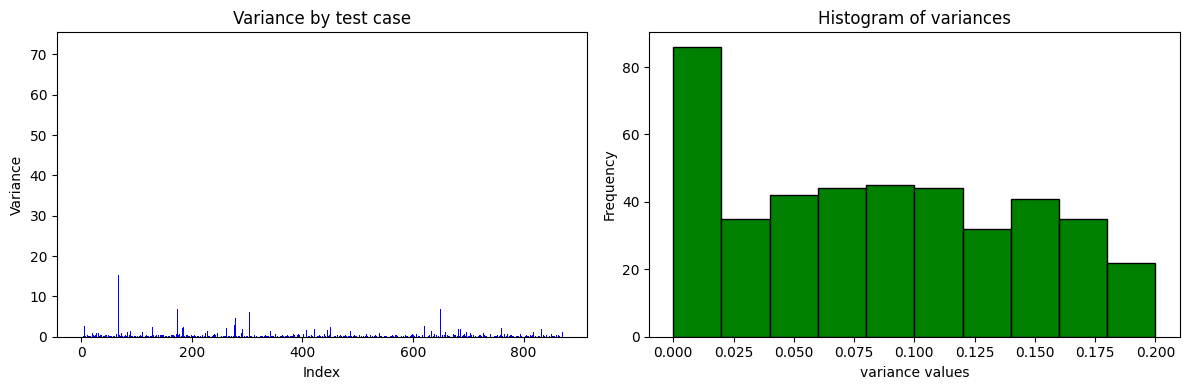

time: 2.87 s (started: 2023-12-14 20:29:43 +00:00)


In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Variance')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black', )
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()